In [52]:
!pip install pytickersymbols
!pip install pandas_datareader 


In [53]:
import numpy as np
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas_datareader import data as web
import yfinance as yf
import statistics
# from pandas_datareader import data


Some helper functions

In [54]:
def port_mean(R,W):
    return np.sum(R*W)

def port_var(W,C):
    return np.dot(np.dot(W,C), W)

In [55]:
def optimize_weights(R,C,rf):
    # utility function which we have to optimize
    def util_function(W,R,C,rf):
        mean = port_mean(R,W)
        var = port_var(W,C)
        util = (mean - rf) / np.sqrt(var)
        return 1/util

    n = len(R)
    W = np.ones(n)/n # initialize weights with equal values
    bound = [(0.,1.) for i in range(n)]  #defining bounds for weights
    print("x")
    constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1.}] #constraint for weights
    print("y")

    optimized_weights = scipy.optimize.minimize(util_function, W, (R,C,rf), method='SLSQP', constraints=constraint, bounds=bound)
    if not optimized_weights.success: raise BaseException(optimized_weights.message)
    return optimized_weights.x


In [56]:
# for different returns we will find optimal weights and mean, variance 
# which will help in plotting graph
def optimize_frontier(R,C,rf):
    # utility function for a particular return 
    def util_function(W,R,C,r):
        mean = port_mean(R,W)
        var = port_var(W,C)
        penalty = 100 * abs(mean-r)
        return var + penalty

    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)

    for r in np.linspace(min(R), max(R), num=30):
        W = np.ones(n)/n
        bound = [(0,1) for i in range(n)]  #defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1}] #constraint for weights

        optimize_weights = scipy.optimize.minimize(util_function, W, (R,C,r), method='SLSQP', bounds=bound, constraints=constraint)
        
        if not optimize_weights.success: raise BaseException(optimize_weights.message)

        frontier_weights.append(optimize_weights.x)
        frontier_means.append(r)
        frontier_vars.append(port_var(optimize_weights.x, C))

    return np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights)


Load Data

In [57]:
from pytickersymbols import PyTickerSymbols
stock_data = PyTickerSymbols()
stocks_list = stock_data.get_dow_jones_nyc_yahoo_tickers()
stocks_list.remove('DOW')
len(stocks_list)


30

In [58]:
tickers = yf.Tickers(stocks_list)
market_cap = {}
for str in stocks_list:
    market_cap[str] = tickers.tickers[str].info['marketCap']
# market_cap

In [59]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations
def load_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('dow-jones/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-2000:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(market_cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
# print(prices)
prices = np.array(prices)

In [60]:
class Result:
    def __init__(self, W, tangent_mean, tangent_var, frontier_mean, frontier_var, frontier_weights):
        self.W=W
        self.tangent_mean=tangent_mean
        self.tangent_var=tangent_var
        self.frontier_mean=frontier_mean
        self.frontier_var=frontier_var
        self.frontier_weights=frontier_weights


## Historical Returns

In [61]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def historical_returns(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    print(rows, cols)
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = np.array([])
    for r in range(rows):
        # calculating expected return of portfolio by taking average of all returns in a day
        expreturns = np.append(expreturns, np.mean(returns[r]))
    # calculate covariances
    covars = np.cov(returns)
    expreturns = ((1 + expreturns) ** 250) - 1  # Annualize returns
    print(expreturns)
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

W = np.array(caps) / sum(caps) # calculate market weights from capitalizations
R, C = historical_returns(prices)
rf = .035  # Risk-free rate



30 2000
[-0.01130755  0.12886388  0.26532909  0.1420898   0.19071818  0.12084103
  0.10533432  0.06807616  0.00241015  0.13238363  0.18415563  0.02401724
  0.01374338  0.0893934   0.15943538  0.17089795  0.16760978  0.10703415
  0.27473693  0.08731979  0.10575246  0.2576718  -0.00482325  0.1971149
  0.08667721 -0.04287265  0.02934505  0.09777732  0.13462991  0.17821062]


In [62]:
def get_frontier(R, C, rf):
    W = optimize_weights(R, C, rf)
    tangent_mean = port_mean(R, W)
    tangent_var = port_var(W, C)
    frontier_means, frontier_vars, frontier_weights = optimize_frontier(R, C, rf)
    return Result(W, tangent_mean, tangent_var, frontier_means, frontier_vars, frontier_weights)

In [63]:
result1 = get_frontier(R, C, rf)
n = len(R)

x
y


In [64]:
def display_assets(names, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result: Result, label=None, color='black'):
    from collections import defaultdict
    from IPython.core.display import HTML
    plt.text(result.tangent_var ** .5, result.tangent_mean, ' tangent', verticalalignment='center', color=color)
    plt.scatter(result.tangent_var ** .5, result.tangent_mean, marker='o', color=color), plt.grid(True)
    plt.plot(list(result.frontier_var ** .5), list(result.frontier_mean), label=label, color=color), plt.grid(True)  # draw efficient frontie

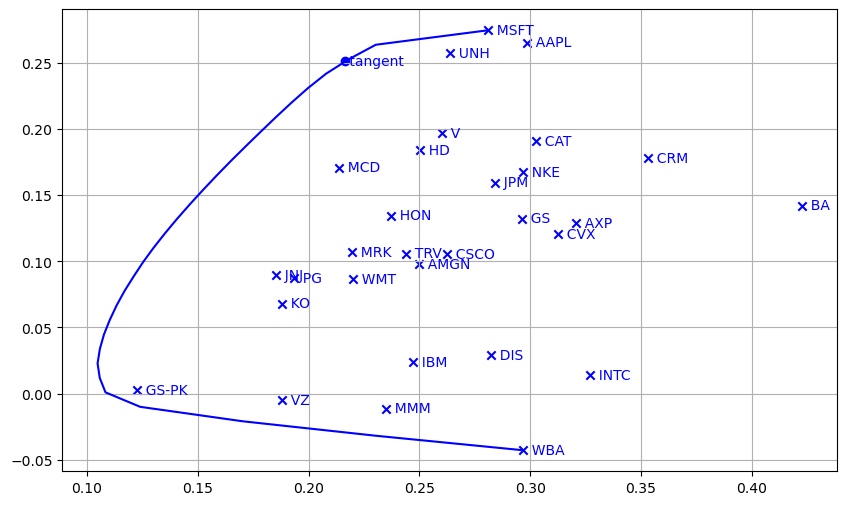

In [65]:
display_assets(names, R, C, color='blue')
display_frontier(result1, color='blue')

## Markowitz model

In [69]:
def load_stock_data(name):
    dataframe = pd.read_csv('dow-jones/%s.csv' % name, index_col=None, parse_dates=['date'])
    prices = list(dataframe['close'])[-2000:] # trailing window 500 days
    return prices

In [70]:
def market_return(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    var = statistics.variance(returns[0]) * 250
    
    market_return = ((1 + np.mean(returns[0])) ** 250) - 1
  
    return market_return, var

In [71]:
spy_prices = load_stock_data('SPY')
rm, market_var = market_return(spy_prices)

In [72]:
# # covariance of each stock return with market return
# cov_matrix = cov_matrix(prices, spy_prices)
# arr = np.array([])
# np.append(arr, market_return)
# print(arr)
# # beta = stock_sigmas/np.sqrt[arr]
# # beta

In [73]:
def markowitz_model(R, C, W, rm, rf, market_var):
    def util_function(W, R, rm, rf):
        mean_port = port_mean(R,W)
        var_port = port_var(W,C)
        print(var_port, market_var)
        result = rf + ((rm-rf) * (np.sqrt(var_port) / np.sqrt(market_var)))
        return result
    res = util_function(W,R,rm,rf)
    return res

In [74]:
def markowitz_portfolio_return(result: Result, C, rf, rm, market_var):
    port_std = np.sqrt(np.array( [port_var(result.W, C)]))
    market_std = np.sqrt(np.array( [market_var] ))
    return rf + (rm-rf) * (port_std/market_std)

markowitz_portfolio_return(result1, C, rf, rm, market_var)

array([0.11066425])

In [75]:
# markowitz_model(R,C,W,rm,rf,market_return)

## Black-litterman reverse optimization

In [76]:
# Calculate portfolio historical return and variance
mean = port_mean(R, W)
var = port_var(W,C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns
print(Pi+rf, R)

[0.14658598 0.19607786 0.23719706 0.22188849 0.17134553 0.17122682
 0.18240345 0.12150315 0.07295824 0.19351119 0.17333922 0.15407133
 0.2084009  0.11948266 0.18396537 0.13684291 0.17923938 0.12232644
 0.22798644 0.12259951 0.14356313 0.1664521  0.10088363 0.19352507
 0.11477012 0.14961728 0.17053101 0.14651708 0.16705338 0.21684952] [-0.01130755  0.12886388  0.26532909  0.1420898   0.19071818  0.12084103
  0.10533432  0.06807616  0.00241015  0.13238363  0.18415563  0.02401724
  0.01374338  0.0893934   0.15943538  0.17089795  0.16760978  0.10703415
  0.27473693  0.08731979  0.10575246  0.2576718  -0.00482325  0.1971149
  0.08667721 -0.04287265  0.02934505  0.09777732  0.13462991  0.17821062]


x
y


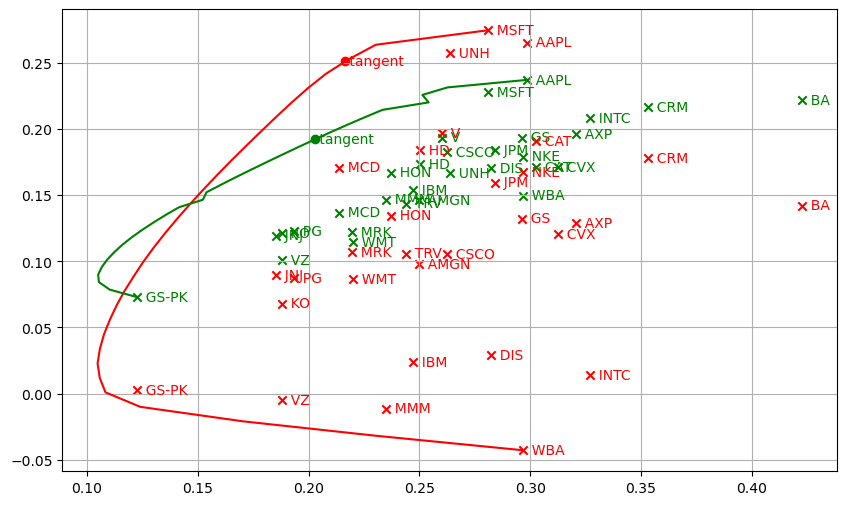

In [77]:
result2 = get_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(result1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(result2, label='Implied returns', color='green')

##### Determine views to the equilibrium returns and prepare views (Q) and link (P) matrices

In [78]:
def create_views_and_link_matrix(names, relative_views, absolute_views):
    r, a, c = len(relative_views), len(absolute_views), len(names)
    Q = [relative_views[i][3] for i in range(r)]  # view matrix
    if(absolute_views):
        for i in absolute_views:
            Q.append(i[1]);
    P = np.zeros([r+a, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(relative_views):
        name1, name2 = relative_views[i][0], relative_views[i][2]
        P[i, nameToIndex[name1]] = +1 if relative_views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if relative_views[i][1] == '>' else +1
    for i, v in enumerate(absolute_views):
        name  = absolute_views[i][0]
        P[i+r, nameToIndex[name]] += 1
    return np.array(Q), P

    

relative_views = [('AAPL', '>', 'MSFT', 0.03)]

absolute_views = [('MSFT', 0.30),
                    ('AAPL', 0.33),
                    ('MCD', 0.12),
                    ('JPM', -0.048),
                    ('CVX', -0.127,
                     ('NKE', 0.051))]

Q, P = create_views_and_link_matrix(names, relative_views, absolute_views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
P = pd.DataFrame(P)
P.columns = stocks_list
display(P)

Views Matrix


,Views
0,0.030
1,0.300
2,0.330
3,0.120
4,-0.048
5,-0.127


Link Matrix


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
tau = 0.025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = np.linalg.inv(np.dot(tau, C))  #(tau.C) inverse
sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)  # (P^T.omega^-1).P
sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)  # ((Tau.C)^-1).Pi
sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)   # (P^T.omega^-1).Q
Pi_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))   

result3 = get_frontier(Pi_adj + rf, C, rf)

x
y


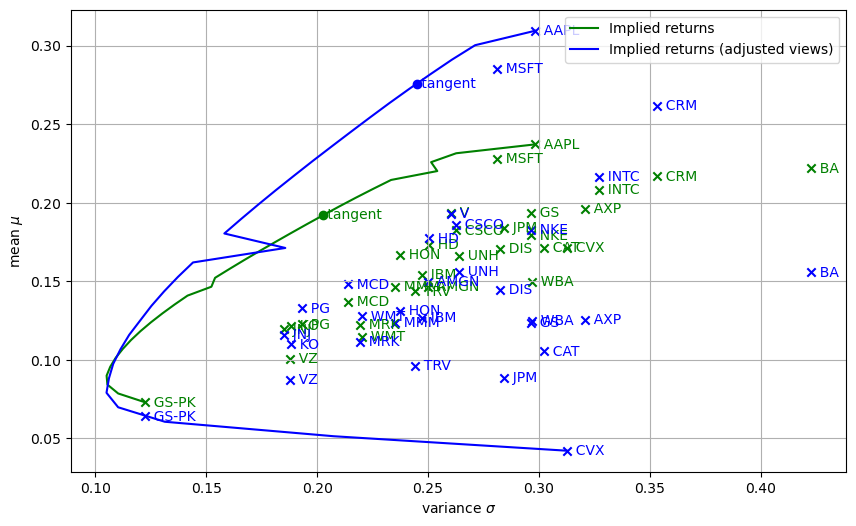

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.0,0.0,0.465891,5.609693e-16,2.519756e-17,0.0,0.0,2.605763e-17,6.032884e-17,0.0,...,4.576836e-17,4.975751e-17,5.172669e-17,0.0,0.045907,1.716841e-17,0.0,0.0,1.623259e-17,0.010946


In [84]:
display_assets(names, Pi+rf, C, color='green')
display_frontier(result2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(result3, label='Implied returns (adjusted views)', color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': result3.W}, index=names).T)
